# Facial Emotion Recognition

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

img_l, img_w = 48, 48
num_classes = 7

def count_exp(path, set_):
    dict_ = {}
    for x in os.listdir(path):
        dir_ = path + x
        dict_[x] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### Graphical representation of training data

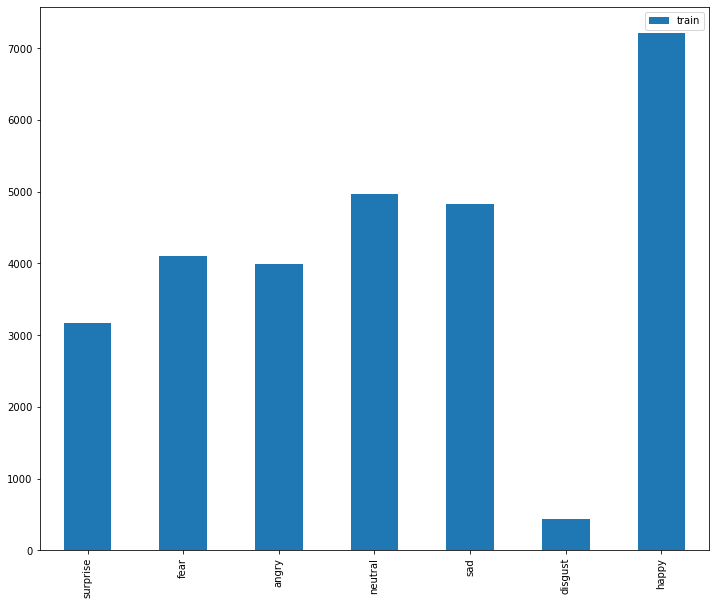

In [4]:
train_count.transpose().plot(kind='bar', figsize=(12,10))

### Graphical representation of testing data 

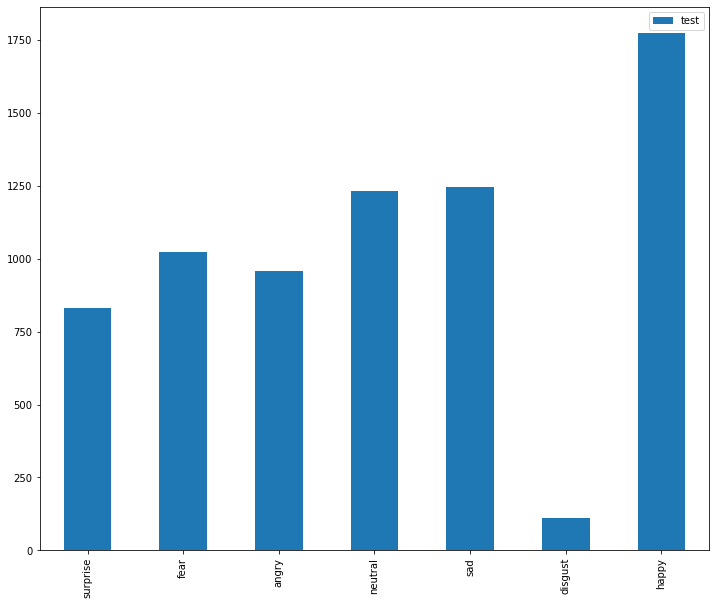

In [5]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

### Display sample images

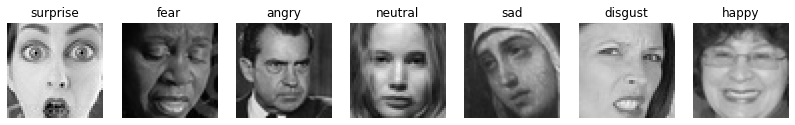

In [6]:
plt.figure(figsize=(14,22))
i = 1
for x in os.listdir(train_dir):
    img = load_img((train_dir + x +'/'+ os.listdir(train_dir + x)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(x)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
image_size= 48 # image is a 48*48 grid of pixels
batch_size= 64 # number of images to process at a time
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [9]:
def fer_model(input_size, num_classes=7):
    fer_model = tf.keras.models.Sequential()
    fer_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_l, img_w,1)))
    fer_model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(MaxPooling2D(pool_size=(2, 2)))
    fer_model.add(Dropout(0.25))


    fer_model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(MaxPooling2D(pool_size=(2, 2)))
    fer_model.add(Dropout(0.25))
    

    fer_model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(MaxPooling2D(pool_size=(2, 2)))
    fer_model.add(Dropout(0.25))


    fer_model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(MaxPooling2D(pool_size=(2, 2)))
    fer_model.add(Dropout(0.25))

    fer_model.add(Flatten())

    fer_model.add(Dense(256))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(Dropout(0.25))
    
    
    fer_model.add(Dense(512))
    fer_model.add(BatchNormalization())
    fer_model.add(Activation('relu'))
    fer_model.add(Dropout(0.25))

    fer_model.add(Dense(num_classes, activation = 'softmax'))
    optimizer = Adam(lr = 0.0001 , decay = 1e-6)
    fer_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    fer_model.summary
    return fer_model

In [10]:
fer_model = fer_model((img_l,img_w,1), num_classes)
fer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       2

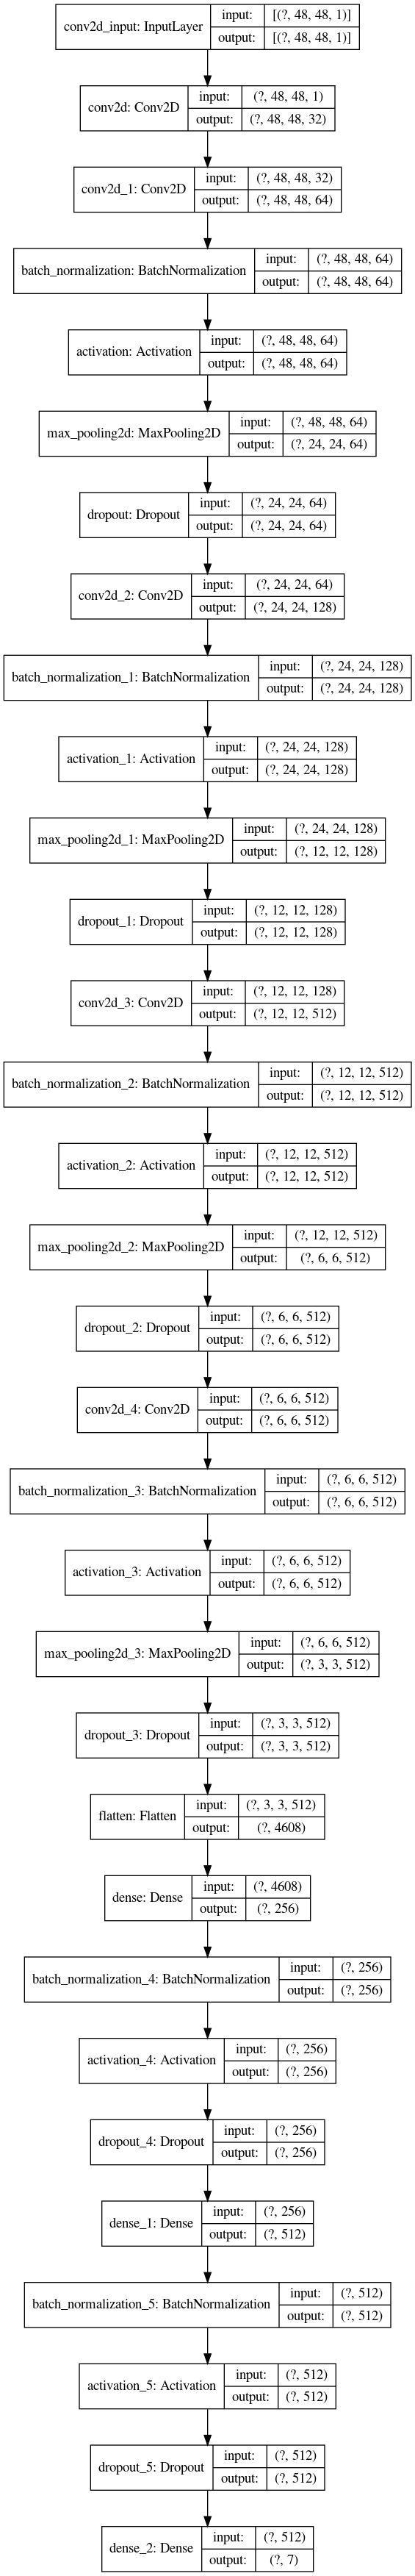

In [11]:
plot_model(fer_model, to_file='fer_model.png', show_shapes=True, show_layer_names=True)

## Training the model

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

# Checkpointing

In [13]:
chkpt_path = 'fer_model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chkpt_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callback = [checkpoint, reduce_lr, csv_logger]

In [14]:
fer_model_hist = fer_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 callbacks=callback,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 8.4183 - accuracy: 0.2231
Epoch 00001: val_loss improved from inf to 7.48729, saving model to fer_model.h5
448/448 [==============================] - 212s 473ms/step - loss: 8.4183 - accuracy: 0.2231 - val_loss: 7.4873 - val_accuracy: 0.2475
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 6.7023 - accuracy: 0.2613
Epoch 00002: val_loss improved from 7.48729 to 5.87606, saving model to fer_model.h5
448/448 [==============================] - 38s 85ms/step - loss: 6.7023 - accuracy: 0.2613 - val_loss: 5.8761 - val_accuracy: 0.2699
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 5.2504 - accuracy: 0.2977
Epoch 00003: val_loss improved from 5.87606 to 4.59153, saving model to fer_model.h5
448/448 [==============================] - 37s 82ms/step - loss: 5.2504 - accuracy: 0.2977 - val_loss: 4.5915 - val_accuracy: 0.3153
Epoch 4/100
448/448 [==============================] - ET

## Loss and Accuracy plot

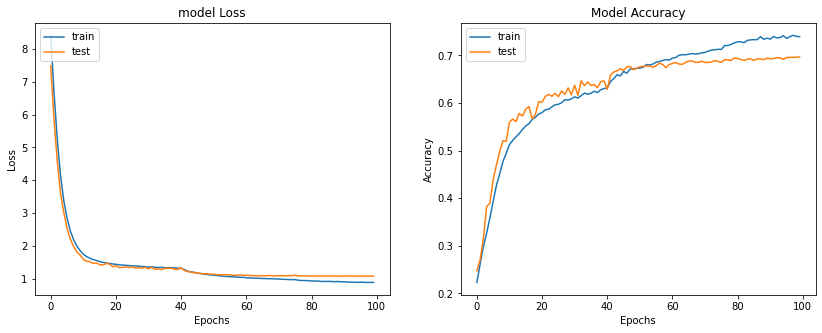

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(fer_model_hist.history['accuracy'])
plt.plot(fer_model_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(fer_model_hist.history['loss'])
plt.plot(fer_model_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model evaluation

In [16]:
def model_data(model):
    train_loss, train_accu = fer_model.evaluate(training_set)
    test_loss, test_accu = fer_model.evaluate(test_set)
    return print("Train accuracy = {:.2f} , Validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [17]:
model_data(fer_model)

113/113 [==============================] - 5s 46ms/step - loss: 1.0741 - accuracy: 0.6966
Train accuracy = 82.54 , Validation accuracy = 69.66


In [18]:
fer_model.save_weights('fer_model_bestweights.h5')

### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 554   63  463 1035  740  731  409]
 [  54    5   50  114   72   81   60]
 [ 519   57  449 1088  773  712  499]
 [ 953  101  796 1888 1422 1238  817]
 [ 625   77  551 1263  949  899  601]
 [ 621   82  574 1245  885  837  586]
 [ 441   57  320  799  634  559  361]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.11      0.12      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.19      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



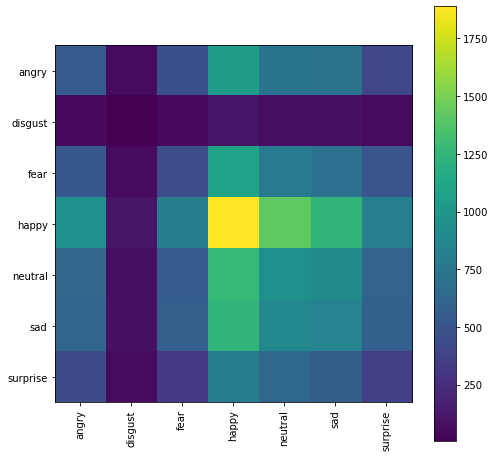

In [20]:
y_pred = fer_model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {value:key for key,value in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

Confusion Matrix
[[127  17  75 257 203 163 116]
 [ 13   2   7  36  23  15  15]
 [145  10 118 262 199 167 123]
 [257  16 207 426 373 275 220]
 [164  19 122 321 244 218 145]
 [163  16 141 308 266 200 153]
 [101  15  82 209 187 162  75]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.02      0.02      0.02       111
        fear       0.16      0.12      0.13      1024
       happy       0.23      0.24      0.24      1774
     neutral       0.16      0.20      0.18      1233
         sad       0.17      0.16      0.16      1247
    surprise       0.09      0.09      0.09       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.16      7178



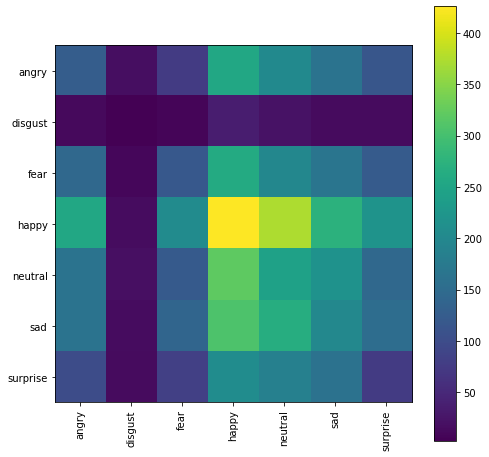

In [21]:
y_pred = fer_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {value:key for key,value in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [22]:
emotions = {0:'angry',
            1:'disgust',
            2:'fear',
            3:'happy',
            4:'neutral',
            5:'sad',
            6:'surprise'}

path = '../input/emotor-test-set'

In [23]:
datagen = ImageDataGenerator(rescale=1/255.)

pred_generator = datagen.flow_from_directory(path,
                                             batch_size=64,
                                             class_mode=None,
                                             shuffle=False,
                                             target_size=(image_size, image_size),
                                             color_mode='grayscale',)

Found 7178 images belonging to 1 classes.


In [25]:
preds = fer_model.predict(pred_generator)
preds = tf.argmax(preds, axis=1).numpy()

In [26]:
images = os.listdir(os.path.join(path, 'EMOTOR_TEST'))
pred_dict = [{'img_name':img, 'label':emotions[pred]} for img, pred in zip(images, preds)]

In [27]:
import csv
with open('predictions.csv', 'w', newline='') as f:
    fieldnames=['img_name', 'label']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(pred_dict)

In [28]:
from IPython.display import FileLink
FileLink(r'./fer_model.h5')

/kaggle/working/fer_model.h5